In [20]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [21]:
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

In [22]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [23]:
df=df.drop(columns=['GBP_USD_H-L'])

In [24]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
28


In [25]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [26]:
# Function to generate time series data
sequence_length = 60
window =10

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return np.array(X_store), np.array(y_store)

In [27]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3079
Test sample 129


In [28]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

print(X_train.shape, y_train.shape)

(1505, 60, 28) (1505, 10)


In [29]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_test.shape, y_test.shape)

(30, 60, 28) (30, 10)


# Proposed Approach

In [30]:
import tensorflow
from tensorflow.keras import regularizers, initializers

In [31]:
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU

In [32]:
#Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation=tf.keras.layers.PReLU() ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation=tf.keras.layers.PReLU()),
    tf.keras.layers.Dense(64, activation=tf.keras.layers.PReLU()),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.PReLU())
])

In [33]:
model.layers

In [34]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

# Method for Calculating feature importance :https://github.com/rebelosa/feature-importance-neural-networks

In [35]:
class VarImpVIANN(tf.keras.callbacks.Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        self.n = 0
        self.M2 = 0.0

    def on_train_begin(self, logs={}, verbose = 1):
        if self.verbose:
            print("VIANN version 1.0 (Wellford + Mean) update per epoch")
        self.diff = self.model.layers[0].get_weights()[0]
        
    def on_epoch_end(self, batch, logs={}):
        currentWeights = self.model.layers[0].get_weights()[0]
        
        self.n += 1
        delta = np.subtract(currentWeights, self.diff)
        self.diff += delta/self.n
        delta2 = np.subtract(currentWeights, self.diff)
        self.M2 += delta*delta2
            
        self.lastweights = self.model.layers[0].get_weights()[0]

    def on_train_end(self, batch, logs={}):
        if self.n < 2:
            self.s2 = float('nan')
        else:
            self.s2 = self.M2 / (self.n - 1)
        
        scores = np.sum(np.multiply(self.s2, np.abs(self.lastweights)), axis = 1)
        
        self.varScores = (scores - min(scores)) / (max(scores) - min(scores))
        if self.verbose:
            print("Most important variables: ",
                  np.array(self.varScores).argsort()[-10:][::-1])

In [36]:
VIANN = VarImpVIANN(verbose=1)

In [37]:
model_history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                   batch_size=10, 
                   epochs=1, shuffle=True
                   )

151/151 [==============================] - 1s 4ms/step - loss: 0.5089 - val_loss: 0.1321


In [38]:
model_history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                   batch_size=10, 
                   epochs=400, shuffle=True,verbose=1, callbacks = [VIANN]
                   )

VIANN version 1.0 (Wellford + Mean) update per epoch
Epoch 1/400
151/151 [==============================] - 1s 4ms/step - loss: 0.2104 - val_loss: 0.0383
Epoch 2/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1706 - val_loss: 0.0638
Epoch 3/400
151/151 [==============================] - 1s 4ms/step - loss: 0.1616 - val_loss: 0.0656
Epoch 4/400
151/151 [==============================] - 1s 4ms/step - loss: 0.1499 - val_loss: 0.0399
Epoch 5/400
151/151 [==============================] - 1s 5ms/step - loss: 0.1459 - val_loss: 0.0418
Epoch 6/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1402 - val_loss: 0.0404
Epoch 7/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.0520
Epoch 8/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1328 - val_loss: 0.0504
Epoch 9/400
151/151 [==============================] - 1s 3ms/step - loss: 0.1298 - val_loss: 0.0690
Epoch 10/400
151/151 [================

Epoch 81/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1092 - val_loss: 0.0904
Epoch 82/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1093 - val_loss: 0.0788
Epoch 83/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1101 - val_loss: 0.0740
Epoch 84/400
151/151 [==============================] - 1s 4ms/step - loss: 0.1093 - val_loss: 0.0746
Epoch 85/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.0859
Epoch 86/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.0717
Epoch 87/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1092 - val_loss: 0.0712
Epoch 88/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1088 - val_loss: 0.0745
Epoch 89/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1080 - val_loss: 0.0779
Epoch 90/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1082

151/151 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.0580
Epoch 240/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1069 - val_loss: 0.0602
Epoch 241/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1066 - val_loss: 0.0603
Epoch 242/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1072 - val_loss: 0.0750
Epoch 243/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1071 - val_loss: 0.0587
Epoch 244/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1072 - val_loss: 0.0631
Epoch 245/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.0610
Epoch 246/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1069 - val_loss: 0.0729
Epoch 247/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1074 - val_loss: 0.0605
Epoch 248/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1077 - v

151/151 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 0.0541
Epoch 398/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1067 - val_loss: 0.0534
Epoch 399/400
151/151 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.0590
Epoch 400/400
151/151 [==============================] - 0s 2ms/step - loss: 0.1066 - val_loss: 0.0548
Most important variables:  [16  4  1 14 10 17 27 22 19  7]


In [39]:
VIANN.varScores

array([0.49725276, 0.87183315, 0.0168233 , 0.03846041, 0.8772092 ,
       0.32006955, 0.0328934 , 0.58959806, 0.42535296, 0.25238767,
       0.7681152 , 0.        , 0.04253659, 0.01519224, 0.8096886 ,
       0.4042396 , 1.        , 0.7390706 , 0.27078024, 0.63356835,
       0.5578697 , 0.22111708, 0.687996  , 0.18358427, 0.02423081,
       0.10613301, 0.06564479, 0.73033834], dtype=float32)

In [40]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':16})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

In [42]:
col_map = plt.get_cmap('tab20c')

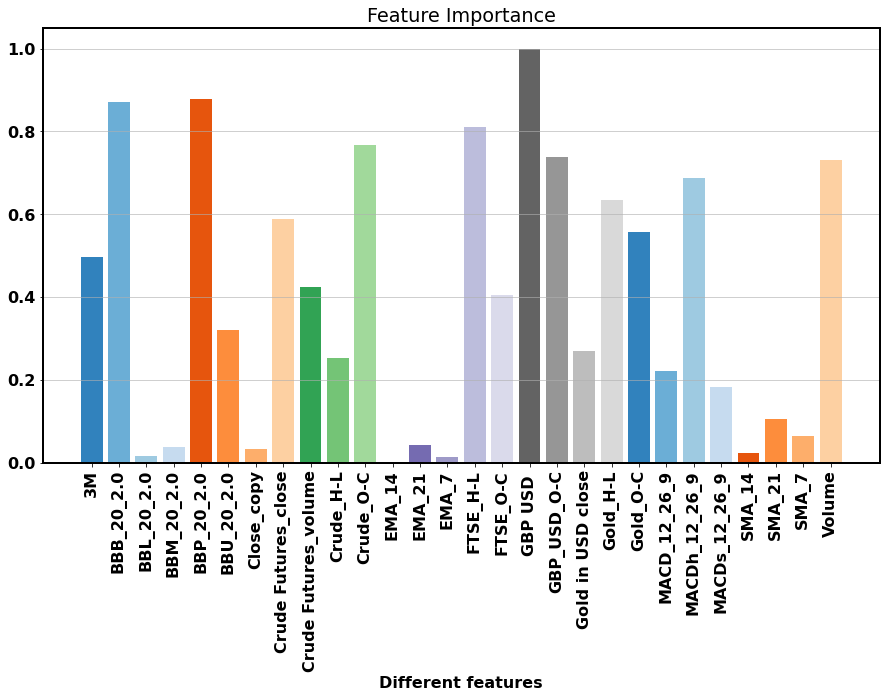

In [43]:
plt.figure(figsize=(15, 8))
plt.bar( range(len(features)),VIANN.varScores,color=col_map.colors)
plt.xlabel('Different features')
plt.xticks(list(range(len(features))), features)
plt.title('Feature Importance')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)
plt.show()